In [0]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import json
import nltk

If you are running on local directory you need to install cuda to run this Project. If you are running on colab and go to Notebook setting and use GPU as Hardware Accelrator

In [2]:
#downloading the dataset
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [57]:
#limiting no of examples
num = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num)

max_len_targ,max_len_inp = max_length(target_tensor),max_length(input_tensor)

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.232)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

23040 23040 6960 6960


In [0]:
#creating tensorflow dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [59]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [0]:
# creating encoder and decoder attention model
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [61]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [63]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
        self.attention = BahdanauAttention(self.dec_units)
    def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
        x = self.fc(output)
        return x, state, attention_weights

In [65]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
# this tensor flow function is for running traning . This is called using sequent
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [69]:
# This bit of code does training in sequential order
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 10 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6264
Epoch 1 Batch 10 Loss 2.8545
Epoch 1 Batch 20 Loss 2.7843
Epoch 1 Batch 30 Loss 2.5891
Epoch 1 Batch 40 Loss 2.3983
Epoch 1 Batch 50 Loss 2.4002
Epoch 1 Batch 60 Loss 2.3752
Epoch 1 Batch 70 Loss 2.2594
Epoch 1 Batch 80 Loss 2.2392
Epoch 1 Batch 90 Loss 2.1763
Epoch 1 Batch 100 Loss 2.1268
Epoch 1 Batch 110 Loss 2.1762
Epoch 1 Batch 120 Loss 2.1323
Epoch 1 Batch 130 Loss 2.1455
Epoch 1 Batch 140 Loss 1.9619
Epoch 1 Batch 150 Loss 2.0191
Epoch 1 Batch 160 Loss 1.8815
Epoch 1 Batch 170 Loss 1.9511
Epoch 1 Batch 180 Loss 1.8761
Epoch 1 Batch 190 Loss 1.8439
Epoch 1 Batch 200 Loss 1.9084
Epoch 1 Batch 210 Loss 1.8832
Epoch 1 Batch 220 Loss 1.9119
Epoch 1 Batch 230 Loss 1.8492
Epoch 1 Batch 240 Loss 1.7785
Epoch 1 Batch 250 Loss 1.8061
Epoch 1 Batch 260 Loss 1.6859
Epoch 1 Batch 270 Loss 1.7781
Epoch 1 Batch 280 Loss 1.6655
Epoch 1 Batch 290 Loss 1.6917
Epoch 1 Batch 300 Loss 1.6340
Epoch 1 Batch 310 Loss 1.7195
Epoch 1 Batch 320 Loss 1.6644
Epoch 1 Batch 330 Los

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_len_targ, max_len_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_len_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_len_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s too fast . <end> 


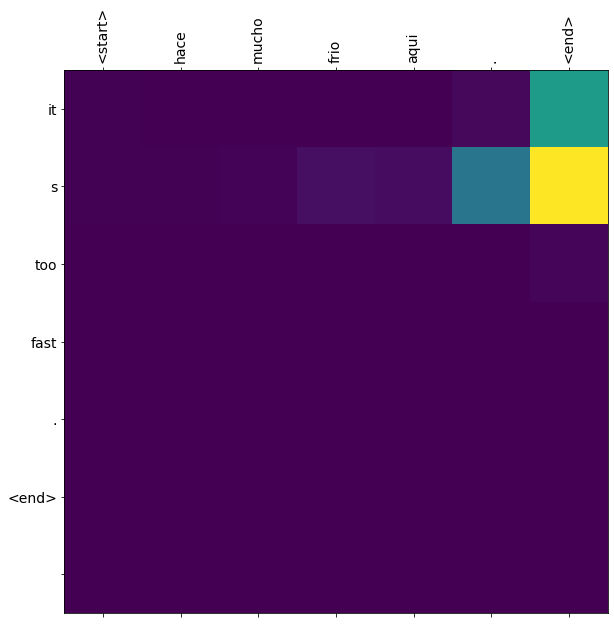

0.7071067811865475


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [43]:
#you can use translate to translate from spanish to english
translate(u'hace mucho frio aqui.')

#if any trouble you can use this link
"""https://stackoverflow.com/questions/32395880/calculate-bleu-score-in-python"""
# refrence should be actual translated value . you can use many sentences as references to get the bleu scores.
reference = ['it','is','too','fast']
#hypothesis is the one you got from translating the below graph tell you the predicted translation
hypo = ["it","s",'too','fast']

#run it against reference and hypothesis to find out the bleu score.
bleu = nltk.translate.bleu_score.sentence_bleu([reference], hypo)
print (bleu)

From this point we will see how to do the same training in parallel

In [20]:
# This part of code allows you to create for virtual gpus on the system if you have only one gpu
# you can change memory limit to 2gb if you want to
gpus = tf.config.experimental.list_physical_devices('GPU')
if(gpus):
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print (logical_gpus)
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


In [0]:
# this we are setting it for parallel training

#intializing mirrored strategy of tensorflow
strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE_PER_REPLICA = 64
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print (strategy.num_replicas_in_sync)

1


I have tried to code this thing in parallel and i have done what i could on this thing. Maybe with some assistance i could have done more. But this is code i wrote for parallel training and i have done parallel encoder and attention training. There is some scope issue i am facing which i don't understand becuase i need to go deep into tensorflow repos. i don;t have much time to understand all this. I won;t be submitting any bleu score for parallel model.

In [0]:
with strategy.scope():
    def train_step(inp, targ, enc_hidden):
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        return list((enc_output,dec_hidden,dec_input))

    @tf.function
    def distributed_train(inp, targ, enc_hidden):
        per_replica_losses = strategy.experimental_run_v2(train_step,
                                                      args=(inp,targ,enc_hidden,))
        
        return strategy.experimental_local_results(per_replica_losses)
    def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_mean(loss_)
    
    num = 5000
    input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num)

    max_len_targ,max_len_inp = max_length(target_tensor),max_length(input_tensor)

    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.232)
    
    BUFFER_SIZE = len(input_tensor_train)
    BATCH_SIZE = 64
    steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
    embedding_dim = 256
    units = 1024
    vocab_inp_size = len(inp_lang.word_index)+1
    vocab_tar_size = len(targ_lang.word_index)+1

    dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE*2, drop_remainder=True)
    dist_dataset = strategy.experimental_distribute_dataset(dataset)
    
    encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
    decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
    
    
    EPOCHS = 10

    for epoch in range(EPOCHS):
        start = time.time()
        
        enc_hidden = encoder.initialize_hidden_state()
        
        total_loss = 0.0
        batch = 0
        for (inp, targ) in dist_dataset:
            batch = distributed_train(inp, targ, enc_hidden)
            targ = targ.values
            loss = 0
            batch = batch[0]
            for i in range(strategy.num_replicas_in_sync):
              targ1 = targ[i]
              with tf.GradientTape() as tape:
                # Teacher forcing - feeding the target as the next input
                dec_input = batch[2].values[i]
                dec_hidden = batch[1].values[i]
                for t in range(1,targ1.shape[1]):
                  # passing enc_output to the decoder
                  predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, batch[0].values[i])
                  loss += loss_function(targ1[:, t], predictions)
                  # using teacher forcing
                  dec_input = tf.expand_dims(targ1[:, t], 1)

                batch_loss = (loss / int(targ1.shape[1]))
                variables = encoder.trainable_variables + decoder.trainable_variables
                gradients = tape.gradient(loss, variables)
                optimizer.apply_gradients(zip(gradients, variables))
                loss +=batch_loss
            total_loss += loss
            batch +=1
            

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
      # saving (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))